# WaterSHEDS
## Modeling Surface Water PFAS Vulnerability

This model evaluates potential sources of PFAS contamination and the vulnerable flowlines that are downstream from these Hazard Sources. The overarching goal is to help stakeholders determine optimal locations for placing PFAS sensors based on their missions goals.

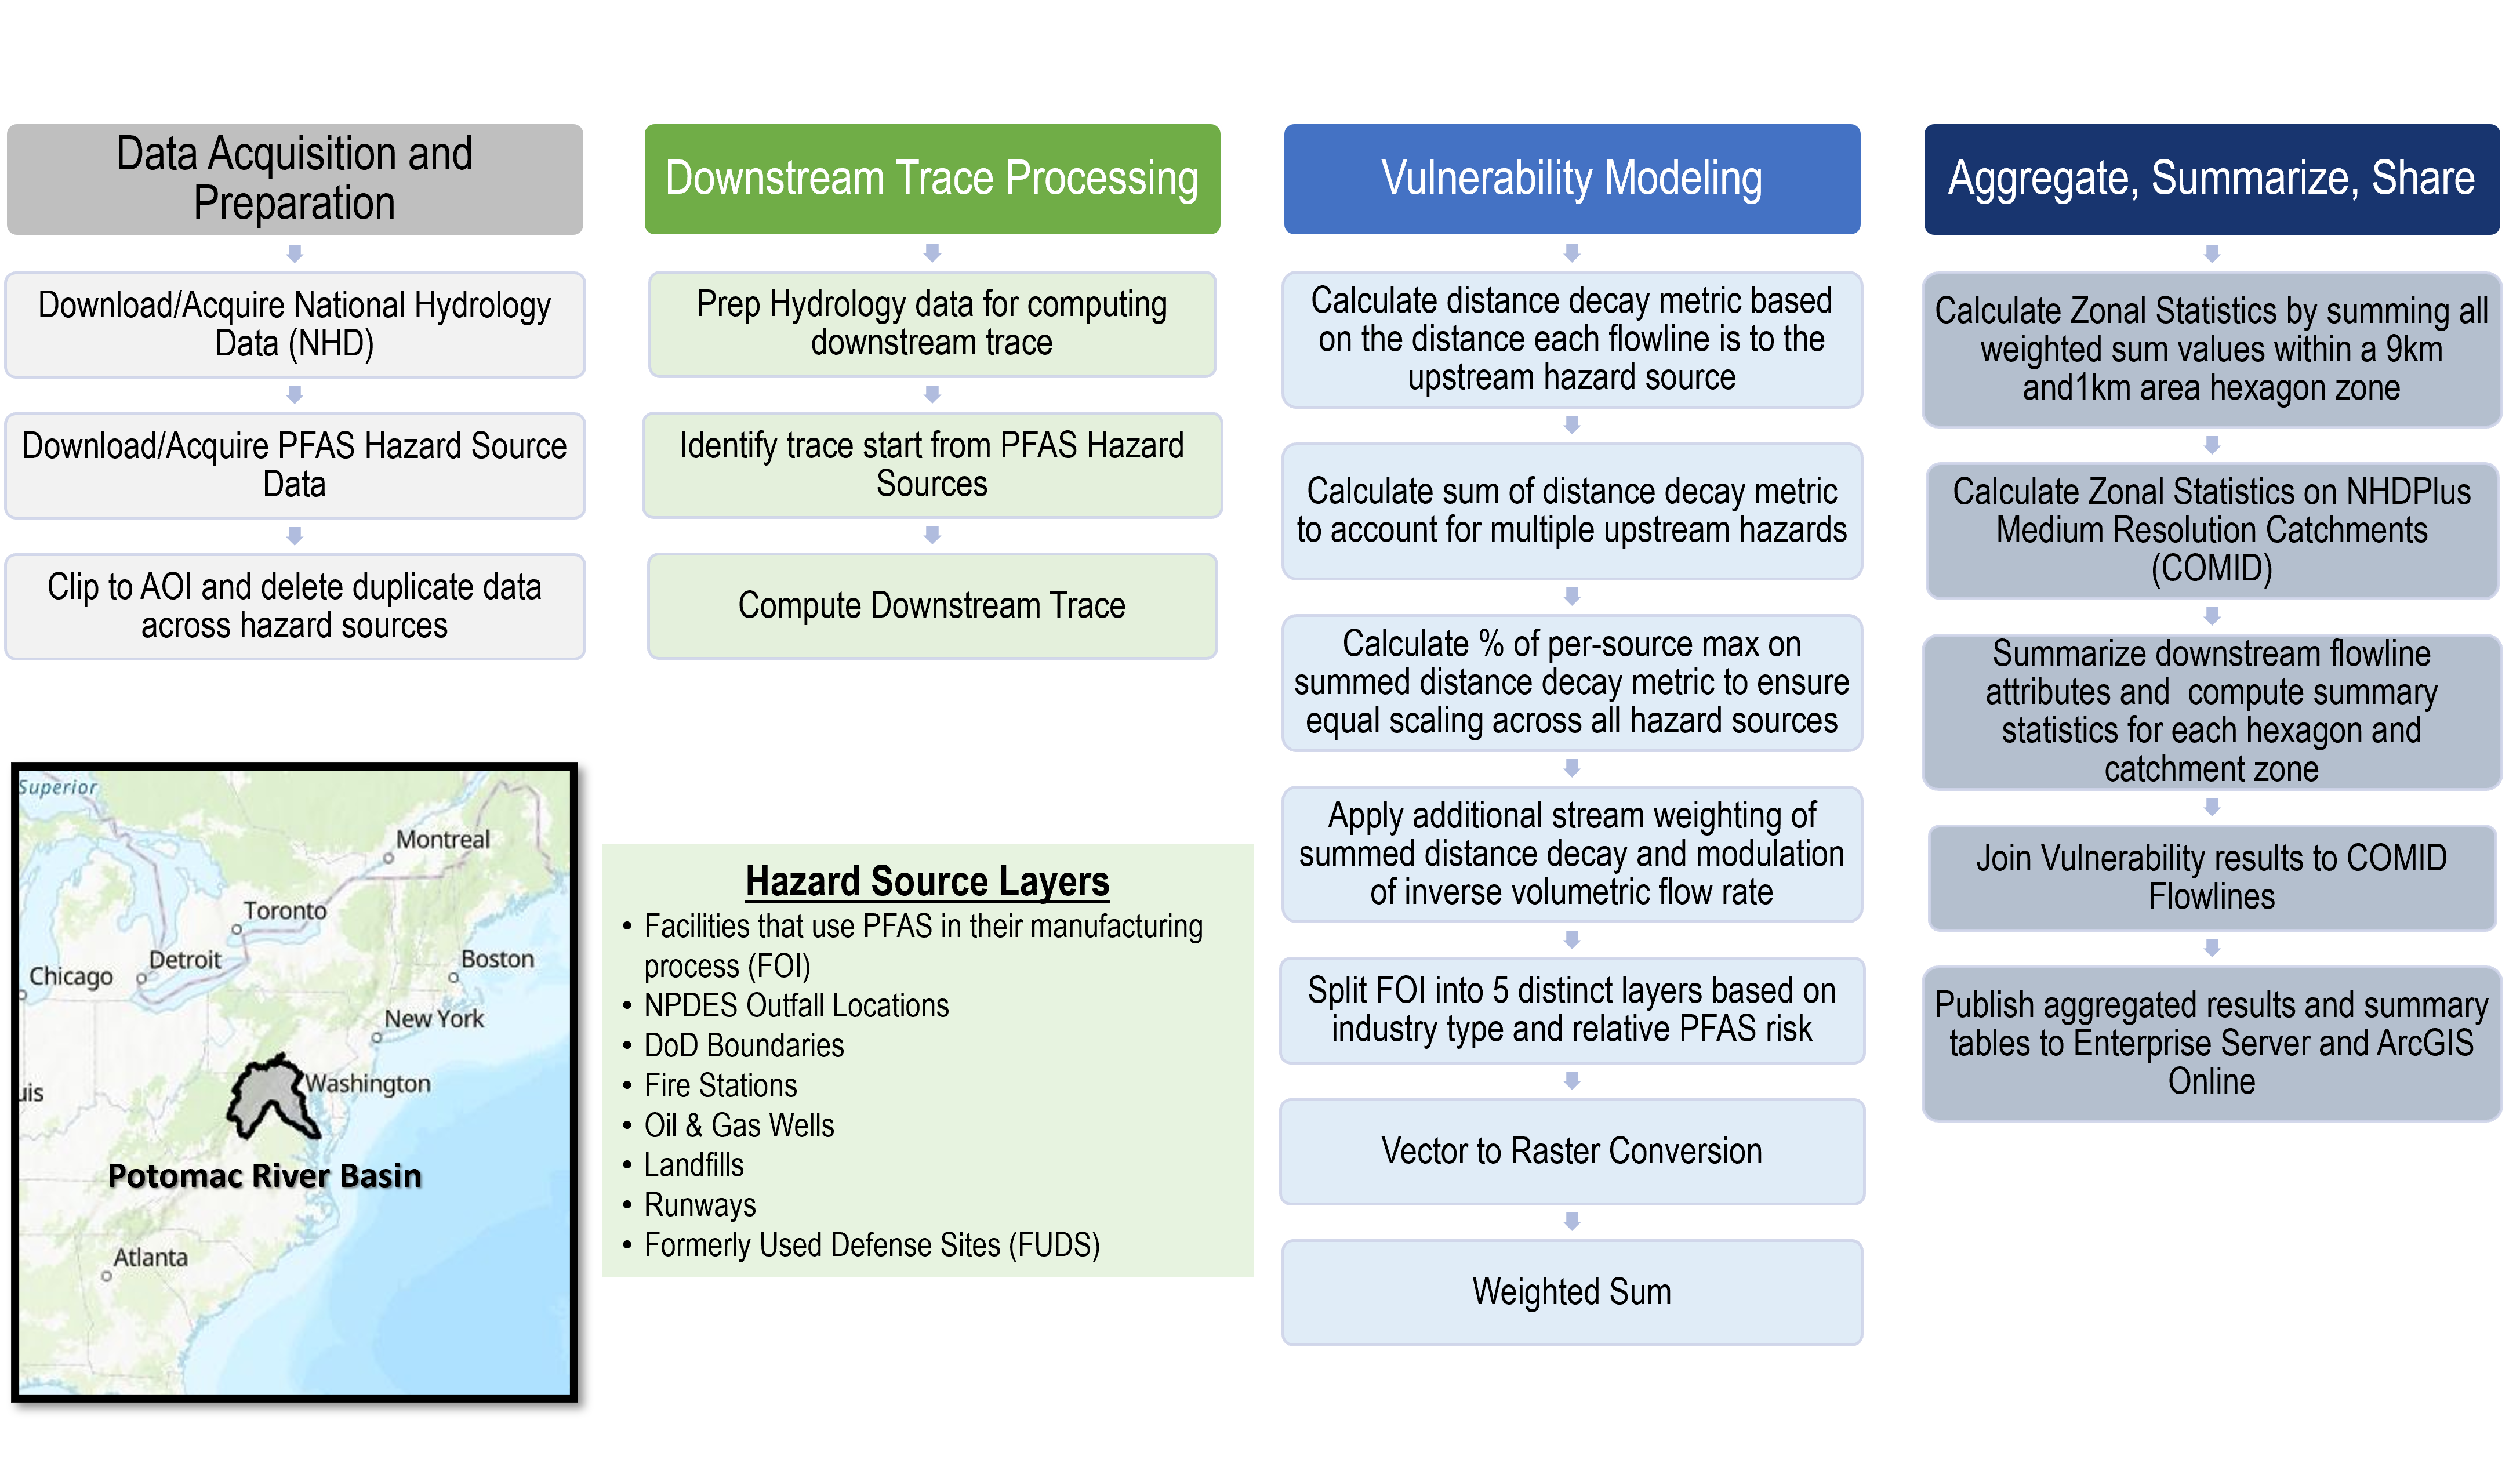

In [36]:
import os
from IPython.display import Image
Image(os.path.join(os.getcwd(),'Images','Potomac_Model_Overview.png'))

## Introduction

Per- and polyfluoroalkyl substances (PFAS) used to manufacture many nonstick and stain-replellent household products have been detected in drinking water in hundreds of locations around the US and beyond. Exposure to these chemicals has been linked to harmful health effects. Additionally, because the molecules contain tough carbon-flourine bonds they persist once they leak into the environment. Our team is pursuing a Risk assessment model approach to help guide a stakeholder or decision maker on optimal locations for sensor placement for PFAS monitoring. The idea behind the risk model is to use a variety of input data layers related to potential sources or hazards along with vulnerability layers such as the downstream flowlines from these sources.

# Imports & Environment Parameters

In [1]:
# Import ArcGIS API for Python
import arcgis
from arcgis.gis import GIS
from arcgis.features import GeoAccessor, GeoSeriesAccessor

# Import ArcPy and Spatial Analyst
import arcpy
from arcpy import env
from arcpy.sa import *

# Import Data Analysis and Visualization modules
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt

# Miscellaneous Imports
import os
import sys
from datetime import datetime
import pdb
from collections import Counter
from pprint import pprint


## Set File Paths for User Input Data

In [23]:

# Environment Settings for ArcPy
arcpy.env.overwriteOutput = True
arcpy.env.outputCoordinateSystem = arcpy.SpatialReference(4269) #NAD83
arcpy.env.parallelProcessingFactor = "100%"

## USER INPUT -- Specify file path of the File Geodatabase workspace:
ws = input("What is the file path of your File Geodatabase workspace: ")
arcpy.env.workspace=ws

## USER INPUT -- Specify the AOI HUC boundary, located in the FGDB workspace, 
## for clipping data and setting extent:
AOI = input('Please enter the name of your AOI HUC boundary that is located in your FGDB workspace: ')

## USER INPUT -- Specify the file path of the input Flowline, VAA table, and EROMMA table:
inputFlowline = input("Please enter the path to the input NHD Flowline Flie: ") 
vaa_Table = input("Please enter the path to the NHD Plus Flowline VAA table: ")
eromma_table=input("Please enter the path to the NHD plus EROMMA file:" )

## USER INPUT -- Specify the file path of the NHDPlus Catchment layer:
NHDPlus_Catchment=input("Please enter the path to the NHDPlus Catchment layer: ")

## USER INPUT -- Specify the file path of the NHDPlus Hydro Geometric Network:
in_geometric_network=input("Please enter the path to the NHDPlus Hydro Geometric Network file: ")

##USER INPUT -- Specify the UTM Zone for your AOI -- Used when converting Vectors to Raster Output 
## Please see the README for a listing of acceptable codes.
utm_output_coordinate_system_number=input("Please enter the EPSG code that corresponds to the UTM Zone for your AOI: ")

##USER INPUT -- Specify the full path to the CSV that has all of the NAICS Codes for facilities within the EPAs Facility Registry Service  
naics_file = input('Please enter the full path to the CSV that contains the NAICS codes for facilities in the FRS: ') 

## USER INPUT -- Run cell and enter a desired run name:
runName = input("Specify a short name to differentiate between outputs: ")

Specify a short name to differentiate between outputs:  0


# Download Aquisition and Preperation

## Download National Hydrology Data

The National Hydrography Dataset Plus High Resolution dataset is used to identify potential downstream vulnerabilities from hazard sources.  
The [NHDPlus HR](https://hydro.nationalmap.gov/arcgis/rest/services/NHDPlus_HR/MapServer) is a national, geospatial model of the flow of water across the landscape and through the stream network. The NHDPlus HR is built using the National Hydrography Dataset High Resolution data at 1:24,000 scale or better, the 1/3 arc-second (10 meter ground spacing) 3D Elevation Program data, and the nationally complete Watershed Boundary Dataset.  

[Access data from the USGS National Map here](https://www.epa.gov/waterdata/get-nhdplus-national-hydrography-dataset-plus-data#NHDPlusV2Map)

[Access data from staged ftp site here](https://prd-tnm.s3.amazonaws.com/index.html?prefix=StagedProducts/Hydrography/NHDPlusHR/Beta/GDB/)

## Download PFAS Hazard Source Data 

In [26]:
## Access the feature service URLs for each PFAS hazard source,
## clip data to AOI, and save to workspace. 

def Download_Data(URL, Layer_Name, Output_Name):
    print(f'Downloading {Layer_Name}')
    arcpy.MakeFeatureLayer_management(URL, Layer_Name)
    arcpy.SelectLayerByLocation_management(Layer_Name, "INTERSECT", AOI, "", "NEW_SELECTION")
    arcpy.CopyFeatures_management(Layer_Name, Output_Name)
    arcpy.management.Delete(Layer_Name)
    
if __name__=="__main__":
    start = datetime.now()
    print("Starting at {}".format(start))
    
    Download_Data("https://services7.arcgis.com/n1YM8pTrFmm7L4hs/arcgis/rest/services/mirta/FeatureServer/1", "DoD_lyr", "DoD_"+str(runName))
    
    Download_Data("https://carto.nationalmap.gov/arcgis/rest/services/structures/MapServer/51", "Firestations_lyr", "Firestations_"+str(runName))
    
    Download_Data('https://services7.arcgis.com/FGr1D95XCGALKXqM/ArcGIS/rest/services/Oil_Wells/FeatureServer/0', 'Oil_lyr', 'Oil_'+str(runName))
    
    Download_Data("https://services.arcgis.com/cJ9YHowT8TU7DUyn/arcgis/rest/services/EPA_Disaster_Debris_Recovery_Data/FeatureServer/0", "Landfills_lyr", "Landfills_"+str(runName))
    
    Download_Data('https://services6.arcgis.com/ssFJjBXIUyZDrSYZ/arcgis/rest/services/Runways/FeatureServer/0', 'Runways_lyr', 'Runways_'+str(runName))
    
    Download_Data('https://services7.arcgis.com/n1YM8pTrFmm7L4hs/ArcGIS/rest/services/FUDS_property_areas/FeatureServer/0', 'FUDS_lyr', 'FUDS_'+str(runName))
    
    Download_Data('https://services.arcgis.com/cJ9YHowT8TU7DUyn/arcgis/rest/services/oeca__echo__npdes_facilities_outfalls/FeatureServer/0', 'NPDES_lyr', 'NPDES_'+str(runName))
    
    end = datetime.now()
    print ("Finished at {}".format(end))

    

Starting at 2024-07-03 12:52:38.746832
Finished at 2024-07-03 12:55:55.889247)


## Download the Facilities of Interest Data

The FRS/Facilities of Interest layer requires some additional pre-processing because the NAICS codes are used to assign a preliminary vulnerability based on the industry type. The first step is to download or access the FRS layer and join the NAICS code table using the key field as the join field. 

The data containing the NAICS code can be downloaded from here [EPA State Combined CSV Download Files](https://ordsext.epa.gov/FLA/www3/state_files/national_combined.zip) The file you want to extract from this ZIP is the"NATIONAL_NAICS_File.csv"

The second step is to run the below cell, which assigns an initial PFAS Risk score based on the industry. The scores being calculated here include: RiskScore, UpperMag and Number_of_PFASs. 

In [6]:
# ## Download the FRS layer 
arcpy.MakeFeatureLayer_management("https://services.arcgis.com/cJ9YHowT8TU7DUyn/ArcGIS/rest/services/FRS_INTERESTS/FeatureServer/0", "FOI_lyr")
arcpy.SelectLayerByLocation_management("FOI_lyr", "INTERSECT", AOI, "", "NEW_SELECTION")
arcpy.CopyFeatures_management("FOI_lyr", f"FOI_{runName}") 
arcpy.management.Delete("FOI_lyr")
print('File downloaded and layer created') 

## Create a pandas dataframe of the National NAICS file downloaded from above 
naics_df = pd.read_csv(naics_file)
print('CSV w/NAICS file has been read')
# ## Adding Risk Score
naics_df['RiskScore'] = naics_df['NAICS_CODE'].apply(lambda x: 100 if x in (928110,3251,325110,325120,325130,325180,325193,325194,325199,562212)
                                                                       else (75 if x in (4881,48811,488111,488119,611519,324110) 
                                                                             else (50 if x in (3133,313310,313320,3141,314110,314120,3149,314910,314994,314999,3371,337110,
                                                                                               337121,337122,337124,337125,337127,3372,337211,337212,337214,337215,3379,337910,
                                                                                               337920,3262,326211,326212,326220,326291,326299,3261,326111,326112,326113,326121,
                                                                                               326122,326130,326140,326150,326160,326191,326199,3221,322110,322121,322122,322130,
                                                                                               3222,322211,322212,322219,322220,322230,322291,322299)
                                                                                  else (25 if x in (922160,3329,332911,332912,332913,332919,332991,332992,332993,332994,332996,
                                                                                                    332999,332312)
                                                                                        else 0
                                                                                       )
                                                                                 )
                                                                            )
                                                                      )

## Calculate the Upper Magnitude of the NAICS category
naics_df['UpperMag'] = naics_df['NAICS_CODE'].apply(lambda x: 10000 if x == 928110
else (1000 if x in (3251, 325110, 325120, 325130, 325180, 325193, 325194, 325199, 562212)
      else (100 if x in (4881, 48811, 488111, 488119, 611519)
            else (10 if x in ( 324110, 3133, 313310, 313320, 3141, 314110, 314120, 3149, 314910, 314994, 314999, 3371, 337110, 337121, 337122, 337124, 
                              337125, 337127, 3372, 337211, 337212, 337214, 337215, 3379, 337910, 337920, 3221,322110,322121,322122,322130,3222,322211,322212,322219,322220,
                              322230,322291,322299, 3262, 326211, 326212, 326220, 326291,326299, 3261, 326111, 326112, 326113, 326121, 326122, 326130, 326140, 326150, 
                              326160, 326191, 326199) 
                  else 0
                 )
            )
      )
                                                                      )
## Calculate number of pfas
naics_df['Number_of_PFASs'] = naics_df['NAICS_CODE'].apply(lambda x: 28 if x in (928110, 4881,48811,488111,488119,611519,324110, 922160)
                                                                             else(13 if x in (3251,325110,325120,325130,325180,325193,325194,325199,3133,313310,313320,3141,314110,
                                                                                              314120,3149,314910,314994,314999,3371,337110,337121,337122,337124,337125,337127,3372,
                                                                                              337211,337212,337214,337215,3379,337910,337920,3221,322110,322121,322122,322130,3222,
                                                                                              322211,322212,322219,322220,322230,322291,322299,3262,326211,326212,326220,326291,
                                                                                              326299,3261,326111,326112,326113,326121,326122,326130,326140,326150,326160,326191,
                                                                                              326199)
                                                                                  else (11 if x in (562212,3329,332911,332912,332913,332919,332991,332992,332993,332994,332996,
                                                                                                    332999, 332312)
                                                                                        else 0
                                                                                        )
                                                                                  )
                                                                             )
## Save the dataframe as a new CSV
out_csv = os.path.join(os.path.dirname(naics_file), 'NATIONAL_NAICS_FILE_wCALCULATIONS.csv')
naics_df.to_csv(out_csv, index=False)
print('CSV saved') 
                       
arcpy.TableToTable_conversion(out_csv,ws, 'National_NAICS2')
print('Table created')

## Convert the Registry_ID field to a TEXT (stored as a BIGINT) so it can be used in the join
arcpy.management.AddField(in_table='National_NAICS2', field_name='REGISTRY_ID_1', field_type='TEXT')
print('Field added')

## calculate temporary field valule
arcpy.management.CalculateField(in_table = 'National_NAICS2', 
                                    field = 'REGISTRY_ID_1',
                                    expression = '!REGISTRY_ID!',
                                    expression_type = "PYTHON3",
                                    field_type = 'TEXT'
                                )
print('Field calculated') 

## Join FRS layer (on REGISTRY_ID) with NAICS file (on REGISTRY_ID) 
arcpy.management.JoinField(f"FOI_{runName}", "REGISTRY_ID", 'National_NAICS2', 'REGISTRY_ID_1', fields = ['NAICS_CODE','RiskScore','UpperMag','Number_of_PFASs'])


C:\Users\bmcmillan\AppData\Local\Temp\ipykernel_13688\1602369601.py:9: DtypeWarning: Columns (2,3,4,5,6,7,8,13,14,15,16,17,18,19,20,21,22,23,24,25,26,28,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  naics_df = pd.read_csv(naics_file)


CSV w/NAICS file has been read
CSV saved
Table created
Field added
Field calculated


<Result 'C:\\Users\\bmcmillan\\Projects\\Potomac_PFAS_Local\\FinalRun\\FINAL_RUN_POTOMAC\\FINAL_RUN_POTOMAC.gdb\\FOI'>

# Downstream Trace Network Processing

## Prepare Hydrology Data for Computing Trace

In [33]:
## Join the NHDFlowline layer and the NHDPlusFlowlineVAA table to get network, stream level,
## stream order, stream calculator, hydroseq, and divergence.
## Join NHDFlowline layer and NHDPlusEROMMA tables to get qema (Estimated guage adjusted flow).

#Join VAA attributes
arcpy.management.JoinField(inputFlowline, "NHDPlusID", vaa_Table, "NHDPlusID", "streamleve;streamorde;streamcalc;hydroseq;divergence" )

# Join EROMMA attributes
arcpy.management.JoinField(inputFlowline, "NHDPlusID", eromma_table, "NHDPlusID", "qema")

#Output the joined data to a new feature layer
arcpy.CopyFeatures_management(inputFlowline, "NHDFlowlineVAA_EROMMA")

<Result 'C:\\Users\\bmcmillan\\Projects\\Potomac_PFAS_Local\\FinalRun\\Round2\\Results.gdb\\NHDFlowlineVAA_EROMMA'>

## Identify Hazard Starting Points for Downstream Trace

In [34]:
## Determine the starting flowline for each hazard source by identifying the
## catchment and NHDPlusID that intersects with each hazard source.

NHDFlowline_Layer="NHDFlowlineVAA_EROMMA"

# Loop through the downloaded and clipped hazard source data.
hazard_list = arcpy.ListFeatureClasses('*_'+str(runName))
for fc in hazard_list:
    print(f'Processing {fc}')
    x=fc.index("_"+str(runName)t)
    
    # Add a new field called HazardSource and populate with the Hazard Source category.
    outHazardFieldName = '"{0}"'.format(fc[:x])
    arcpy.management.CalculateField(fc, "HazardSource", outHazardFieldName, "PYTHON3",
                                    '', "TEXT", "NO_ENFORCE_DOMAINS")
    
    outHazardName=fc[:x]+"_SpatialJoin"
    outStartFlowlineName=fc[:x]+"_StartingFlowline"
    output_hazards=os.path.join(ws,outHazardName)
    output_flowline=os.path.join(ws,outStartFlowlineName)
    
    # Create a fieldmapping object containing all fields from each hazard source 
    # and the NHDPlusID field from the catchments layer.
    fms = arcpy.FieldMappings()
    fms.addTable(fc)
    fm = arcpy.FieldMap()

    for field in arcpy.ListFields(NHDPlus_Catchment, "NHDPlusID"):
        fm.addInputField(NHDPlus_Catchment, field.name)
        
    fms.addFieldMap(fm)
     
    # Join the catchment and associated NHDPlusID to each hazard source.

    if "DoD" in fc or "FUDS" in fc:
         arcpy.analysis.SpatialJoin(fc, NHDPlus_Catchment, output_hazards, "JOIN_ONE_TO_MANY","KEEP_ALL", fms, "INTERSECT", None, '')
    else: 
         arcpy.analysis.SpatialJoin(fc, NHDPlus_Catchment, output_hazards, "JOIN_ONE_TO_ONE", "KEEP_ALL", fms, "INTERSECT", None, '')
    
    # Rename the NHDPlusID field to "Starting_NHDPlusID".
    arcpy.management.AlterField(output_hazards, "NHDPlusID", "Starting_NHDPlusID", "Starting_NHDPlusID")
    
    # Join attributes from the hazard source spatial join output to the flowlineline output
    # using NHDPlusID as the join field.
    arcpy.management.MakeFeatureLayer(NHDFlowline_Layer, "NHDFlowline_Layer_Temp", '', None,)
    arcpy.management.AddJoin("NHDFlowline_Layer_Temp", "NHDPlusID", output_hazards, "Starting_NHDPlusID", "KEEP_COMMON")
    arcpy.conversion.ExportFeatures("NHDFlowline_Layer_Temp", output_flowline)

Processing FOI_0
Processing DoD_0
Processing Firestations_0
Processing Oil_0
Processing Landfills_0
Processing Runways_0
Processing FUDS_0
Processing NPDES_0


In [ ]:
## Split intersercting flowlines, which is required to compute the downstream trace.

fcListLine = arcpy.ListFeatureClasses("*_StartingFlowline", feature_type="line")
for fcLine in fcListLine:
    print(f'Processing {fcLine}')
    arcpy.SplitByAttributes_analysis(fcLine, ws, ['HazardSource','Starting_NHDPlusID'])

Processing FOI_StartingFlowline


## Create and Enable Trace Network
### **WARNING**: THIS PERMANENTLY MODIFIES THE INPUT DATA.  
Unless if you make a copy of the `in_geometric_network` (a.k.a the NHDPlus Hydro Geometric Network NHDPlus Hydro Geometric Network) that you defined above, this can only be ran once. 

In [ ]:
# IMPORTANT NOTICE -- the tool ConvertGeometricNetworkToTraceNetwork PERMANENTLY MODIFIES the input data.
# This cell can only be run ONCE with the HYDRO NET input layer. 

# Convert the geometric network to a trace network.
arcpy.tn.ConvertGeometricNetworkToTraceNetwork(in_geometric_network, "HydroNet_Trace")
# Enable network topology.
arcpy.tn.EnableNetworkTopology(os.path.join(os.path.dirname(in_geometric_network), 'HydroNet_Trace'), 10000, "ENABLE_TOPO")

## Compute Downstream Trace from Each Hazard Source

Note: In this repo, there is a file called `hazard_Processing_mp.py`.  That file will preform the same steps as below, but will do them in parallel.  If you have access to a machine with lots of storage (est. minimum 500 GB free), or you are working in a very small area of interest, you can use this file to speed up the processing. 

In [ ]:
## Trace Downstream Flowlines from Hazard Sources.

# HYDRO_NET_TRACE_Network="HydroNet_Trace"
HYDRO_NET_TRACE_Network=os.path.join(os.path.dirname(in_geometric_network), 'HydroNet_Trace')

## Loop through all split flowlines.
fcListLine = arcpy.ListFeatureClasses("*_0",feature_type="line")
for fcLine in fcListLine:
    
    field_names_fcLine = []
    field_names = []
    field_names_fcLine = [f.name for f in arcpy.ListFields(fcLine, "Starting_NHDPlusID")]
    
    traceGroupName = fcLine+"_TraceGroup"
    outName="tempTrace_"+fcLine
    output_file = os.path.join(ws,outName) 
    
    # Compute Trace without aggregation, which results in a selection. 
    arcpy.tn.Trace(HYDRO_NET_TRACE_Network, "DOWNSTREAM", fcLine, 
                   '', #'TN_Temp_Barriers' 
                   "NO_DIRECTION", '', "EXCLUDE_BARRIERS", "DO_NOT_VALIDATE_CONSISTENCY", 
                   "DO_NOT_IGNORE_BARRIERS_AT_STARTING_POINTS", "IGNORE_INDETERMINATE_FLOW", None, None, 
                   "BOTH_JUNCTIONS_AND_EDGES", None, None, "NETWORK_LAYERS;SELECTION", "NEW_SELECTION", 
                   "CLEAR_ALL_PREVIOUS_TRACE_RESULTS", '', "Trace_Results_Aggregated_Points", 
                   "Trace_Results_Aggregated_Lines", traceGroupName, "DO_NOT_USE_TRACE_CONFIGURATION", '', None)
    
    print("FinishedTrace "+traceGroupName)
    copyTraceGroupNameFlowline = traceGroupName+"\\"+"NHDFlowline"
     
    # Copy/save the selected trace to the output file location and join the 
    # Starting_NHDPlusID field to each output.
    arcpy.management.CopyFeatures(copyTraceGroupNameFlowline, output_file, '', None, None, None)  
    arcpy.JoinField_management(output_file,"NHDPlusID", fcLine, "Starting_NHDPlusID", field_names_fcLine)
    
    field_names = [f.name for f in arcpy.ListFields(fcLine, "Starting_NHDPlusID")]

    # Create a list with tuples where each tuple contains the attribute values
    # to pass onto the update cursor to populate fields.
    # The Starting_NHDPlusID source attribute values are copied to all rows in the downstream trace.  

    def rows_as_dicts(cursor):
        colnames = cursor.fields
        for row in cursor:
            yield dict(zip(colnames, row))

    fc_dict = {}
    with arcpy.da.SearchCursor(fcLine, list(field_names)) as sc:
        for row in rows_as_dicts(sc):
            fc_dict.update(row)

    field_range = range(len(field_names))
    

    # Use an insert cursor to populate Starting_NHDPlusID for each row in downstream trace.
    with arcpy.da.UpdateCursor(output_file, list(field_names)) as cursor:
        fRange = range(len(fc_dict))
        fVals = list(fc_dict.values())
        for row in cursor:
            for Index in fRange:
                row[Index] = fVals[Index]   
                cursor.updateRow(row)

## Merge Trace Networks for Each Hazard Source

In [4]:
## Merge all trace layers of the same hazard source into a single Trace layer. 

fcs = arcpy.ListFeatureClasses("tempTrace_*", feature_type="line")

def Merge_Hazards(fcs, hazard, outfc):
    for fc in fcs:
        if fc.startswith(hazard):
            print(fc)
            arcpy.management.Merge(fc, outfc)
        
if __name__=="__main__":
    start = datetime.now()
    print("Starting at {})".format(start))
    
    Merge_Hazards(fcs, "tempTrace_DoD", "Trace_DoD")
    Merge_Hazards(fcs, "tempTrace_Firestations", "Trace_Firestations")
    Merge_Hazards(fcs, "tempTrace_FUDS", "Trace_FUDS")
    Merge_Hazards(fcs, "tempTrace_Runways", "Trace_Runways")
    Merge_Hazards(fcs, "tempTrace_NPDES", "Trace_NPDES")
    Merge_Hazards(fcs, "tempTrace_Landfills", "Trace_Landfills")
    Merge_Hazards(fcs, "tempTrace_Oil", "Trace_Oil")
    Merge_Hazards(fcs, "tempTrace_FOI", "All_Risk_Trace_FOI")
    
    end = datetime.now()
    print ("Finished at {})".format(end))

Starting at 2024-06-25 13:05:51.076346)
Merging tempTrace_DoD
Merging tempTrace_Firestations
Merging tempTrace_FUDS
Merging tempTrace_Runways
Merging tempTrace_NPDES
Merging tempTrace_Landfills
Merging tempTrace_Oil
Merging tempTrace_FOI
Finished at 2024-06-26 03:41:02.814397)
Wall time: 14h 55min 6s


## Assign Risk Score to Facilities

In [ ]:
## Asign a risk score to different facility types and split the merged Facilties of Interest
## layer into 5 new layers based on this risk score.

#The output field name will not include the table name.
arcpy.env.qualifiedFieldNames = False

## Join the merged FOI layer to the FOI Starting Flowline layer.
arcpy.management.AddJoin("All_Risk_Trace_FOI", "Starting_NHDPlusID", "FOI_StartingFlowline", "NHDPlusID")

foi_fc="All_Risk_Trace_FOI"

## Break out FOI into 5 separate layers based on Risk Score, UpperMap, and Number_of_PFASs.
risk1="RiskScore <=25 And UpperMag <= 0 And Number_of_PFASs <= 11"
risk25="RiskScore <=25 And Number_of_PFASs >= 13"
risk50="RiskScore > 25 And RiskScore <= 50"
risk75="RiskScore > 50 And RiskScore <= 75"
risk100="RiskScore > 75"

def Split_FOI(foi_fc, out_lyr, query, output_name):
    print(f'Processing {risk1}')
    arcpy.management.MakeFeatureLayer(foi_fc, out_lyr, query)
    arcpy.management.CopyFeatures(out_lyr, output_name)
    arcpy.management.Delete(out_lyr)
    
if __name__=="__main__":
    start = datetime.now()
    print("Starting at {}".format(start))
    
    Split_FOI(foi_fc, "out1", risk1, "Trace_FOI_RiskScore1")
    Split_FOI(foi_fc, "out25", risk25, "Trace_FOI_RiskScore25")
    Split_FOI(foi_fc, "out50", risk50, "Trace_FOI_RiskScore50")
    Split_FOI(foi_fc, "out75", risk75, "Trace_FOI_RiskScore75")
    Split_FOI(foi_fc, "out100", risk100, "Trace_FOI_RiskScore100")
    
    end = datetime.now()
    print ("Finished at {})".format(end))

# Vulnerability Modeling

## Distance Decay

In [ ]:
## USER INPUT -- Required because the overwrite output environment is not allowing for identical File Geodatabase Table names. 
tableName = input("Specify a unique table name: ")

## Calculate the distance between a downstream flowline from its upstream hazard source
## using the hydroseq and length parameters.
## Assign a weight to those that are further downstream.

# Don't show scientific notation
pd.options.display.float_format = '{:.2f}'.format

##Processing
fields=['OBJECTID', 'lengthkm', 'Starting_NHDPlusID', 'hydroseq']

#Loop through each hazard source feature class
fcList = arcpy.ListFeatureClasses("Trace_*")
print(fcList)

out_df_list = []
for fc in fcList:
    print(fc)
    # Merge all subsets into single dataframe
    col = 'Starting_NHDPlusID'
    dd_init_val = 1.0 # distance decay initial value, equivalent to theta_0 in eqn
    dd_const_list = [0.0010, 0.0120, 0.7]

    df = pd.DataFrame(data=arcpy.da.SearchCursor(fc, fields), columns=fields)
    for dd_const in dd_const_list:
        dd_const_proportionality = dd_const
        dd_name=str(dd_const)[2:]
        outname=fc+"_weight_"+str(dd_name)
        print(outname)
        fieldName_dd="dd_weight_"+str(dd_name)

        outfile=os.path.join(ws,outname)

        # Build dict of counts for each type of hazard id (as indicated by Starting_NHDPlusID value)
        starting_nhdplusid_count_dict = dict(Counter(df[col].to_list()))
        print(len(starting_nhdplusid_count_dict))

        # Loop over hazard ids
        appended_starting_nhdplusid_subsets = []
        for starting_nhdplusid, num_flowlines in starting_nhdplusid_count_dict.items():

            # Get all rows where starting_nhdplusid is the same, then decreasing sort by hydroseq value
            hazard_id_subset = df[df[col]==starting_nhdplusid].sort_values(['hydroseq'], ascending=[False])

            # Compute cumulative sum on the lengthkm col, important that this happens AFTER sorting above
            hazard_id_subset['length_sum'] = hazard_id_subset['lengthkm'].cumsum()

            # Compute weighting based on cumulative distance from starting point
            hazard_id_subset[fieldName_dd] = dd_init_val * np.exp(-dd_const_proportionality * hazard_id_subset['length_sum'])

            # Creating a column denoting the UpstreamSource and populating it based on the feature class name -- this is only temporary and we remove it before writing out to disk
            #hazard_id_subset['UpstreamSource'] = fc

            # Append to list to concatenate at the end
            appended_starting_nhdplusid_subsets.append(hazard_id_subset)
            
            
        # Merge all subsets into single dataframe
        out_df = pd.concat(appended_starting_nhdplusid_subsets)
        print(len(out_df))
        ###out_array=out_df.to_records(index=False)
        out_array=out_df.to_records()
        arcpy.da.NumPyArrayToTable(out_array, outfile)

In [ ]:
## Join distance decay tables created in previous step to each downstream trace layer
arcpy.env.overwriteOutput = True

#Loop through each hazard source feature class
fcList = arcpy.ListFeatureClasses("Trace_*")
#print(fcList)
tableList = arcpy.ListTables("Trace_*")
for table in tableList:
    #tableIndex=str(tableList).index("weight")
    x=str(table).find("weight")
    tableSubName = table[:x-1]
    for fc in fcList:
        if fc == tableSubName:
            print(fc)
            print(table)
            fields = arcpy.ListFields(table, "dd_weight*")
            for field in fields:
                print(field.name)
                arcpy.management.JoinField(fc, "OBJECTID", table, "OBJECTID", [field.name])

## Sum and Normalize

In [ ]:
## To account for multiple upstream hazards of the same type the sum of the dist_weights is calculated.
## Calculating the sum of the dist_weights ensures an attribute is retained when 
## converting from vector to raster that takes into account multiple upstream hazards.


def normalize_and_calculate(output_table, output_field, sum_field, normalize_field, normalize_field_data_type):
    '''
     Adds a field to the output table that will contain normalized values based on the sum field
    :param output_table: the name of the table to populate
    :param output_field: field to add to the output_table
    :param sum_field: field in the output_table that we are preforming the sum calculation on  ### this is field1
    :param normalize_field: field that will contain the normalized values in our output_table ### this is field2
    :param normalize_field_data_type: data type of the normalized field to create.
    '''
    
    arcpy.management.AddField(output_table, output_field, normalize_field_data_type, None, None, None, '', "NULLABLE", "NON_REQUIRED", '')
        
    allRows = [i[0] for i in arcpy.da.SearchCursor(output_table, sum_field)]
    max_value = max([row for row in allRows if row != None])
    value=()
    with arcpy.da.UpdateCursor(outTableName, [sum_field, normalize_field]) as upd_cursor:
        for row in upd_cursor:
            if row[0] != None:
                value = (row[0]/max_value)
                row[1] = value
                upd_cursor.updateRow(row)

fcList = arcpy.ListFeatureClasses("Trace*")
for fc in fcList:
#     fName=fc
    outTableName="Table_"+fc+"_SummaryAttributes_dd"
    print(outTableName)
    outFile=os.path.join(ws,outTableName)
    if arcpy.Exists(outFile):
        arcpy.Delete_management(outFile)
        print(f'Deleted {outTableName}')
    
    #Loop through fields and find fields starting with dd_weight and compute sum summary attributes
    fieldList = ["dd_weight_001", "dd_weight_012", "dd_weight_7"]
    fields = arcpy.ListFields(fc, "dd_weight*")
    value_table = arcpy.ValueTable(2)
    for field in fields:
        value_table.addRow([field.name, "SUM"])

    vtab = "{0}".format(value_table)
    print(vtab)
    arcpy.gapro.SummarizeAttributes(fc, outTableName, "NHDPlusID", vtab, None, None, None)
    arcpy.management.JoinField(fc, "NHDPlusID", outTableName, "NHDPlusID", fieldList)
    
    for field in fieldList: 
        sum_field = f'SUM_{field}'
        norm_field = f'norm_SUM_{field}'
        normalize_and_calculate(output_table = outTableName, output_field = norm_field, sum_field=sum_field, normalize_field=norm_field, normalize_field_data_type="DOUBLE")

In [ ]:
#Join distance decay summary tables to each trace feature class.

fcList = arcpy.ListFeatureClasses("Trace*")
for fc in fcList:
    fName=fc
    TableName="Table_"+fName+"_SummaryAttributes_dd"
    arcpy.management.JoinField(fc, "NHDPlusID", TableName, "NHDPlusID")

## Incorporate Volumetric Flowrate Options

In [ ]:
##Options for implementing distance decay and flow rate calculations on downstream flowlines. 

#Allowing graphics to show in notebook using magic function
%matplotlib inline

#List of Fields to import to numpy array
fields = ["NHDPlusID", "qema", "dd_weight_001", "dd_weight_012", "dd_weight_7",
          "SUM_dd_weight_001", "SUM_dd_weight_012", "SUM_dd_weight_7", 
          "norm_SUM_dd_weight_001", "norm_SUM_dd_weight_012", "norm_SUM_dd_weight_7"]
fcList = arcpy.ListFeatureClasses("Trace*")
for fc in fcList:
    outName="Table_"+fc+"_dd_flowCalc"
    output = os.path.join(ws,outName)
    if arcpy.Exists(output):
        arcpy.Delete_management(output)
    
    arr = arcpy.da.FeatureClassToNumPyArray(fc, fields)
    df = pd.DataFrame(arr, columns=fields)

    maxQEMA = df['qema'].max()
    
    minQEMA = df['qema'].min()
    
    # Replace null or NaN values with zeros
    df['qema'] = df['qema'].fillna(0)
    
    # filter out 0 QEMA values first and then get min of series
    z = df.loc[df['qema'] !=0, 'qema'].min()
    df['qema'].replace(0,z,inplace=True)

    # Add and calculate normalizedQEMA column
    df['normQEMA'] = df['qema']/maxQEMA
    
    pd.options.display.float_format = '{:.9f}'.format
    df.sort_values(by='normQEMA', ascending=False)

    df['invQEMA'] = 1/df['qema']
    
    # filter out inf values first and then get max of series
    m = df.loc[df['invQEMA'] !=np.inf, 'invQEMA'].max()
    df['invQEMA'].replace(np.inf,m,inplace=True)

    df['norm_invQEMA'] = df['invQEMA']/m
    m2 = df.loc[df['norm_invQEMA'] !=np.inf, 'norm_invQEMA'].max()
    df['norm_invQEMA'].replace(np.inf,m2,inplace=True)
    df.sort_values(by='norm_invQEMA', ascending=False)
    
    # calculate modulated inverse volumetric flowrate
    df['MIVFR'] = (1/(df['qema'].pow(0.1)))
    
    # filter out inf values first and then get max of series
    m3 = df.loc[df['MIVFR'] !=np.inf, 'MIVFR'].max()
    df['MIVFR'].replace(np.inf,m3,inplace=True)
    
    # calculate normalized modulated inverse volumetric flowrate
    df['norm_MIVFR'] = df['MIVFR']/m3
    m4 = df.loc[df['norm_MIVFR'] !=np.inf, 'norm_MIVFR'].max()
    df['norm_MIVFR'].replace(np.inf,m4,inplace=True)
    df.sort_values(by='norm_MIVFR', ascending=False)
    
    # Alpha and beta are both 1.0.  
    alpha_b = 1.00000
    beta_b = 1.00000 
      
    # option 31-36: Normalize 1/df['QEMA'].pow(0.1).  Make alpha and Beta the same at 1.0
    # each option uses different distance decay rate.  
    # Options 31-33 use machine learning generated weighting in weighted sum portion of the model in cells below
    df['option31'] = (alpha_b*df['norm_SUM_dd_weight_7']) + (beta_b*df['norm_MIVFR'])
    df['option32'] = (alpha_b*df['norm_SUM_dd_weight_001']) + (beta_b*df['norm_MIVFR'])
    df['option33'] = (alpha_b*df['norm_SUM_dd_weight_012']) + (beta_b*df['norm_MIVFR'])
    
    # Options 31-33 use weighting based off lit/research in weighted sum portion of the model in cells below
    df['option34'] = (alpha_b*df['norm_SUM_dd_weight_7']) + (beta_b*df['norm_MIVFR'])
    df['option35'] = (alpha_b*df['norm_SUM_dd_weight_001']) + (beta_b*df['norm_MIVFR'])
    df['option36'] = (alpha_b*df['norm_SUM_dd_weight_012']) + (beta_b*df['norm_MIVFR'])
      
    df.sort_values(by='option34', ascending=False)
    
    df3 = df[['NHDPlusID', 'qema', 'MIVFR', 'norm_MIVFR', 
              'dd_weight_001', 'dd_weight_012', 'dd_weight_7',
              'SUM_dd_weight_001', 'SUM_dd_weight_012', 'SUM_dd_weight_7', 
              'norm_SUM_dd_weight_001', 'norm_SUM_dd_weight_012', 'norm_SUM_dd_weight_7', 
              'option31', 'option32', 'option33', 'option34', 'option35', 'option36']]
    out_array = df3.to_records()
    
    arcpy.da.NumPyArrayToTable(out_array, output)
    
    jfields = ["NHDPlusID", "option31", "option32", "option33", "option34", "option35", "option36"]
    arcpy.management.JoinField(fc, "OBJECTID", output, "OBJECTID", jfields)

## Convert Vector Outputs to Raster

In [ ]:
## Convert hydrodem to a 50m raster and reproject to WGS_1984_UTM_Zone_18N. 

sr_temp = arcpy.SpatialReference(int(utm_output_coordinate_system_number))
# with arcpy.EnvManager(outputCoordinateSystem='PROJCS["WGS_1984_UTM_Zone_18N",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-75.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]', cellSize=50):
with arcpy.EnvManager(outputCoordinateSystem=sr_temp, cellSize=50):
    arcpy.management.CopyRaster(
        in_raster="hydrodem",
        out_rasterdataset="NHD_hydrodem_50m_UTM",
        config_keyword="",
        background_value=None,
        nodata_value="2147483647",
        onebit_to_eightbit="NONE",
        colormap_to_RGB="NONE",
        pixel_type="8_BIT_UNSIGNED",
        scale_pixel_value="NONE",
        RGB_to_Colormap="NONE",
        format="GRID",
        transform="NONE",
        process_as_multidimensional="CURRENT_SLICE",
        build_multidimensional_transpose="NO_TRANSPOSE"
    )
    flowline = inputFlowline

    arcpy.conversion.FeatureToRaster(flowline, "OBJECTID", "NHDFlowline_50m_UTMx", 50)

with arcpy.EnvManager(snapRaster="NHDFlowline_50m_UTMx", extent="NHDFlowline_50m_UTMx"):
    out_raster = arcpy.sa.Reclassify(in_raster="NHDFlowline_50m_UTMx", reclass_field="Value", remap="1 500000 0", missing_values="DATA")
    out_raster.save("NHDFlowline_50m_UTM_0x")

In [ ]:
## Convert downtream trace hazard vectors to a raster and rejoin attribute table.

#Raster environment settings
arcpy.env.cellSize="NHD_hydrodem_50m_UTM"
arcpy.env.snapRaster="NHD_hydrodem_50m_UTM"
arcpy.env.outputCoordinateSystem="NHD_hydrodem_50m_UTM"
outCellSize="NHD_hydrodem_50m_UTM"

#Fields to join
fields = ['NHDPlusID', 'Starting_NHDPlusID','qema', 'MIVFR', 'norm_MIVFR', 
              'dd_weight_001', 'dd_weight_012', 'dd_weight_7',
              'SUM_dd_weight_001', 'SUM_dd_weight_012', 'SUM_dd_weight_7', 
              'norm_SUM_dd_weight_001', 'norm_SUM_dd_weight_012', 'norm_SUM_dd_weight_7', 
              'option31', 'option32', 'option33', 'option34', 'option35', 'option36']

fcListTraces = arcpy.ListFeatureClasses("Trace_*", feature_type="line")
for fcTrace in fcListTraces:
    print(fcTrace)
    outName = "Raster_"+fcTrace
    print(outName)
    output_raster_name = os.path.join(ws,outName)
    print(output_raster_name)
        
    arcpy.conversion.FeatureToRaster(fcTrace, "OBJECTID", output_raster_name)
    arcpy.management.JoinField(output_raster_name, "VALUE", fcTrace, "OBJECTID", fields)
    

In [ ]:
## Add the NHDFlowline raster to all rasterized downstream trace layers.
## This ensures all flowlines are represented in the model, including those with zero upstream hazards. 

#Raster environment settings
arcpy.env.cellSize="NHD_hydrodem_50m_UTM"
arcpy.env.snapRaster="NHD_hydrodem_50m_UTM"
arcpy.env.outputCoordinateSystem="NHD_hydrodem_50m_UTM"
outCellSize="NHD_hydrodem_50m_UTM"

fields = ['NHDPlusID', 'Count', 'Starting_NHDPlusID', 'qema', 'MIVFR', 'norm_MIVFR', 
              'dd_weight_001', 'dd_weight_012', 'dd_weight_7',
              'SUM_dd_weight_001', 'SUM_dd_weight_012', 'SUM_dd_weight_7', 
              'norm_SUM_dd_weight_001', 'norm_SUM_dd_weight_012', 'norm_SUM_dd_weight_7', 
              'option31', 'option32', 'option33', 'option34', 'option35', 'option36']

                
flowlineRaster="NHDFlowline_50m_UTM_0x"

## defining the function that we will pass into calculate field to identify records with a value of 0
expression_str = """def set_val(curr_val): 
    if curr_val == 0: 
        return 0
    else:
        return curr_val
        """

rasterList = arcpy.ListRasters("Raster_Trace_*")
for raster in rasterList:
    rasterName=raster[13:]
    tableName = f'{rasterName}_table'

    cellStatRasterName=f'SWt_{rasterName}'
    cellStatRaster=os.path.join(ws,cellStatRasterName)
    print(cellStatRaster, tableName)

    # Export Raster Attribute table from each raster to join with cell stat raster
    arcpy.management.CopyRows(raster, tableName)

    ## Calculate Cell Statistics to add flowline raster to each trace raster
    out_raster = arcpy.sa.CellStatistics([raster, flowlineRaster], "MAXIMUM", "DATA", "SINGLE_BAND", 90, "AUTO_DETECT")
    out_raster.save(cellStatRaster)

    arcpy.management.BuildRasterAttributeTable(cellStatRaster)
    
    arcpy.management.JoinField(cellStatRaster, "Value", tableName, "Value", fields)
    
    # Select flowline row where values are null and calculate fields with value 0
    arcpy.management.SelectLayerByAttribute(cellStatRaster, "NEW_SELECTION", "Value = 0",
                                            "NON_INVERT")
    
    ## Loop through fields starting with "option" and calculate 0 on just the selected row
    fields_in_raster = arcpy.ListFields(raster, "option*")
    for field in fields_in_raster:
        exp = f'''set_val(!{field.name}!) '''
        # arcpy.management.CalculateField(cellStatRaster, field.name, "0", "PYTHON3", field_type="DOUBLE",enforce_domains = "NO_ENFORCE_DOMAINS")
        arcpy.management.CalculateField(cellStatRaster, field.name, exp, "PYTHON3", code_block = expression_str, field_type="DOUBLE",enforce_domains = "NO_ENFORCE_DOMAINS")

## Weighted Sum Modeling

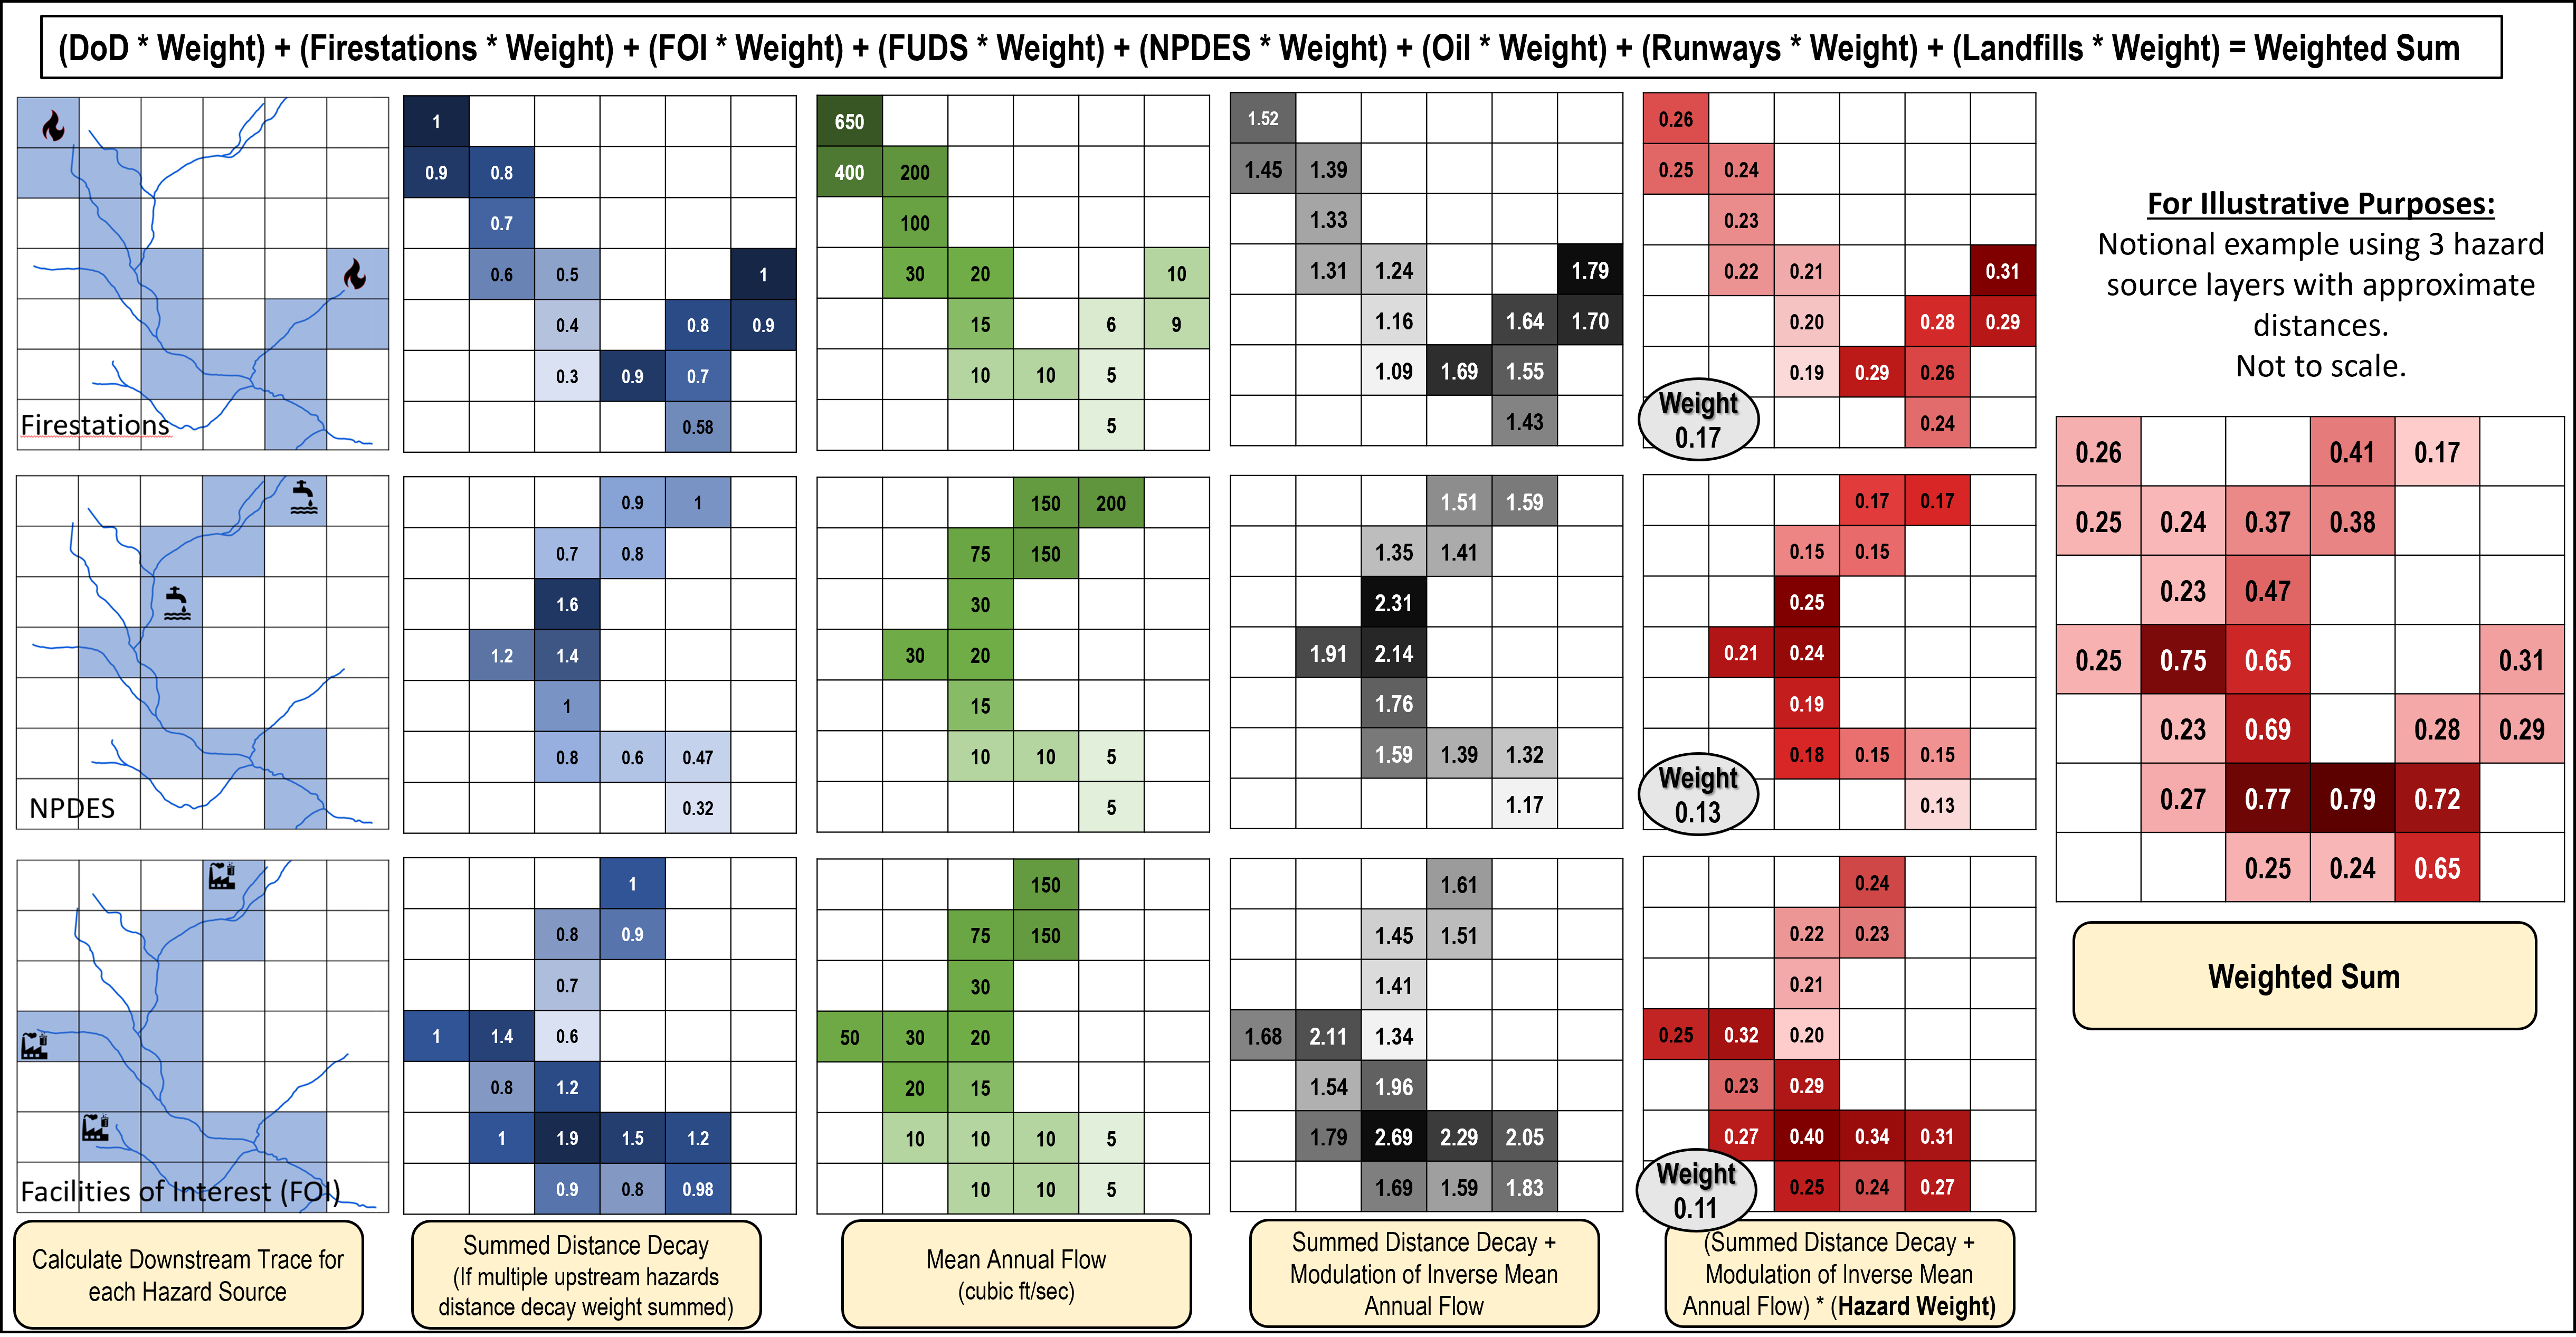

In [24]:
## STOPPED HERE
from IPython.display import Image
Image(os.path.join(os.getcwd(),'Images','IllustrativeGraphicDetailed.png'))

In [ ]:
# Weighted Sum

# output_coordinate_system_raster_path = r"\\gdac-vm4\gisdata\PFAS_Data\Potomac\Potomac.gdb\NHD_hydrodem_50m_UTM"
output_coordinate_system_raster_path = os.path.join(ws, "NHD_hydrodem_50m_UTM")
output_coordinate_system_raster = arcpy.Raster(output_coordinate_system_raster_path)
# arcpy.env.outputCoordinateSystem= output_coordinate_system_raster.spatialReference 

cellsize_raster_path = "NHD_hydrodem_50m_UTM"
cellsize_raster = arcpy.Raster(cellsize_raster_path)

arcpy.env.cellSize = (cellsize_raster.meanCellHeight + cellsize_raster.meanCellWidth)/2

# extent_raster_path = r"\\gdac-vm4\gisdata\PFAS_Data\Potomac\Potomac.gdb\NHDFlowline_50m_UTMx"
extent_raster_path =  os.path.join(ws, "NHDFlowline_50m_UTMx")
extent_raster = arcpy.Raster(extent_raster_path)
arcpy.env.extent = arcpy.Extent(extent_raster.extent.XMin,extent_raster.extent.YMin,extent_raster.extent.XMax,extent_raster.extent.YMax)

def Create_List(raster, att, weight):
    try:
        newList = [raster, att, weight]
    except Exception as e:
        print(e.message)

    finally:
        return newList
    
fieldList = ['option34', 'option35', 'option36']
rasterList = arcpy.ListRasters("SWt*")
##### Default Values are #####
#DoD Facilities: 0.17
#Facilities of Interest (FOI) - 100 = 0.15
#Facilities of Interest (FOI) - 75 = 0.13
#Facilities of Interest (FOI) - 50 = 0.11
#Formerly Used Defense Sites (FUDS) = 0.08
#Runways = 0.08
#Landfills = 0.08
#Facilities of Interest (FOI) - 25 = 0.06
#NPDES Permitted Facilities = 0.06
#Firestations = 0.03
#Oiland Gas Facilities = 0.03
#Facilities of Interest (FOI) - 1 = 0.02
##############################
for field in fieldList:
    WSUMTable = []
    outName = f'ws_{field}'
    WS_Output = os.path.join(ws, outName)
    print(f'------\n{field} \n{outName}\n------')
    for raster in rasterList:
        weight_value = input(f'Please enter the desired weight for {field} - {raster}: ')
        generated_list = Create_List(raster, field, float(weight_value))
        WSUMTable.append(generated_list)
    
    ws_table = arcpy.sa.WSTable(WSUMTable)
    out_weighted_sum = arcpy.sa.WeightedSum(ws_table)
    out_weighted_sum.save(WS_Output)    
    
    #0.04 0.11 0.05

In [ ]:
#Normalize ws output
#Loop through ws outputs and normalize to a 0-1 scale
# rasterList = arcpy.ListRasters("ws_option36")
rasterList = arcpy.ListRasters("ws*")
for raster in rasterList:
    if not raster.endswith('normalized'):
        outName=raster+"_normalized"
        outRaster=os.path.join(ws, outName)
        myraster=arcpy.Raster(raster)
        arcpy.env.extent=myraster
        mymin=myraster.minimum
        mymax=myraster.maximum
        myrange=mymax-mymin

        normalizedRaster=(myraster-mymin)/myrange
        with arcpy.EnvManager(nodata="PROMOTION"):
            arcpy.management.CopyRaster(
                in_raster=normalizedRaster,
                out_rasterdataset=outRaster,
                config_keyword="",
                background_value=None,
                nodata_value="3.402823e+38",
                onebit_to_eightbit="NONE",
                colormap_to_RGB="NONE",
                pixel_type="32_BIT_FLOAT",
                scale_pixel_value="NONE",
                RGB_to_Colormap="NONE",
                format="TIFF",
                transform="NONE",
                process_as_multidimensional="CURRENT_SLICE",
                build_multidimensional_transpose="NO_TRANSPOSE"
            )

In [ ]:
### Set NoData value, convert to 32bit float tif

## Not sure if the variable is supposed to be outputFGDB so that's why i've thrown this in here.. 
def create_fgdb(directory, name):
    '''
    Creates a file geodatabase if a user wants one
    :param directory: name of the base directory to create the FGDB
    :param name: the name of the output FGDB
    '''

    outName = f"{name}"

    outPath = os.path.join(directory, outName)
    if os.path.exists(outPath):
        pass
    else:
        arcpy.CreateFileGDB_management(directory, outName, "CURRENT")

outputFGDB = os.path.join(os.path.dirname(ws),'Split')

if outputFGDB.endswith(".gdb"):
    create_fgdb(os.path.dirname(outputFGDB),os.path.basename(outputFGDB))
    
if not os.path.exists(outputFGDB): 
    os.mkdir(outputFGDB)
    
rasterList = arcpy.ListRasters("*normalized")
#rasterList = arcpy.ListRasters("ws_option*")
for raster in rasterList:
#     outName="x_"+raster[:-11]+".tif"
    outName = f'x_{raster.replace("_normalized",".tif")}'
    print(outName)
    outRaster=os.path.join(outputFGDB, outName)
    out_tiff=raster[:-10]
    
    #Identify the NoData locations using the IsNull tool
    out_raster_con = arcpy.sa.Con(IsNull(raster), 9999, raster)
    arcpy.env.extent=out_raster_con

    arcpy.management.CopyRaster(out_raster_con, outRaster, "", 9999, 9999, "NONE",
                                "NONE", "32_BIT_FLOAT", "NONE", "NONE", "TIFF", 
                                "NONE", "CURRENT_SLICE", "NO_TRANSPOSE")
    
    arcpy.management.SplitRaster(outRaster, outputFGDB, out_tiff, "SIZE_OF_TILE", "TIFF", "NEAREST", "1 1", "1000 1000", 0, 
                                     "PIXELS", None, None, None, "NONE", "DEFAULT", "")
        
    

  

## Aggregate Results & Configure Summary Attributes <a class="anchor" id="19"></a>

In [ ]:
## Generate output Aggregation Tessellation polygons at 9km and 1km.  
## and NHDPlus Medium Resolution Catchment/COMID scales  
## Area formula is  A = ((3*sqrt3)/2)*s(squared)


def reproject_layer(input_layer, output_name, new_projection): 
    '''
    Reprojects a layer to a new projection
    :param input_layer: Name of the layer to reproject
    :param output_name: Name to save the layer as
    :param new_projection: The EPSG code to reproject the data into 
    :return output_layer: The layer reprojected

    '''
    
    
    try: 
        arcpy.management.Project(
            in_dataset = input_layer, 
            out_dataset=output_name, 
            out_coor_system = arcpy.SpatialReference(int(new_projection))
        )
    except Exception as e: 
        print(f'Error reprojecting {input_layer}. Error is {e}')
    else: 
        return output_name
    


#Environment settings
arcpy.env.outputCoordinateSystem = os.path.join(ws,"NHD_hydrodem_50m_UTM")
arcpy.env.extent = os.path.join(ws,"NHDFlowline_50m_UTMx")
tess_extent = os.path.join(ws,"NHDFlowline_50m_UTMx")

# sr=arcpy.SpatialReference(32618) #WGS_1984_UTM_Zone_18N
sr = int(utm_output_coordinate_system_number)

sr_NAD83=arcpy.SpatialReference(4269) #NAD83
# AOI = os.path.join(ws,"Potomac_HUC4_0207_AOI_UTM")
aoi=AOI
AOI = reproject_layer(aoi, f'{AOI}_reprojected', int(utm_output_coordinate_system_number))

#Generate tessellation polygons at 1km, 9km areas
tess_list = ["1 SquareKilometers", "9 SquareKilometers"]
for tess in tess_list:
    temp_name = tess.replace(" SquareKilometers", "_SquareKilometers")
    x=temp_name.index("_SquareKilometers")
    out_tess="Tessellation_"+temp_name[:x]+"KM"
    print(out_tess)

    tmpTess=arcpy.management.GenerateTessellation(r"memory\temp", tess_extent, "HEXAGON", tess, sr)
    arcpy.management.CalculateGeometryAttributes(tmpTess,[["AreaKM", "AREA"],["PerimeterLength", "PERIMETER_LENGTH"]],
                                                 "KILOMETERS","SQUARE_KILOMETERS")
    
    tmp = arcpy.management.SelectLayerByLocation(tmpTess, "INTERSECT", AOI)
    arcpy.management.CopyFeatures(tmp, out_tess)
    
    arcpy.management.Delete(r"memory\temp")
    arcpy.management.Delete(tmpTess)
    arcpy.management.Delete(tmp)

In [ ]:
## Make NHDPlus Medium Resolution Catchments with COMID a tessellation grid
## to enable aggregation at the COMID/Catchment (medium resolution) scale.


## Download/Access NHDPlusV21 catchment data
# https://www.epa.gov/waterdata/nhdplus-mid-atlantic-data-vector-processing-unit-02
# Catchment Polygons: https://dmap-data-commons-ow.s3.amazonaws.com/NHDPlusV21/Data/NHDPlusMA/NHDPlusV21_MA_02_NHDPlusCatchment_01.7z
# FEATUREID field in catchment polygon is the COMID - Common Identifier
# Access Feature server here: https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/NHDPlusV21/FeatureServer

arcpy.env.outputCoordinateSystem = os.path.join(ws,"NHD_hydrodem_50m_UTM")
arcpy.env.extent = os.path.join(ws,"NHDFlowline_50m_UTMx")
tess_extent = os.path.join(ws,"NHDFlowline_50m_UTMx")
#sr=arcpy.SpatialReference(32618)
sr = int(utm_output_coordinate_system_number)

sr_NAD83=arcpy.SpatialReference(4269) #NAD83
# AOI = os.path.join(ws,"Potomac_HUC4_0207_AOI_reprojected")
# AOI = os.path.join(ws,"Potomac_HUC4_0207_AOI_UTM")
# aoi=AOI
# AOI = reproject_layer(aoi, f'{AOI}_reprojected', int(utm_output_coordinate_system_number))

catchments = os.path.join(ws,"Catchment")

# Select the medium resolution catchments that intersect the AOI and make a copy
tmp = arcpy.management.SelectLayerByLocation(catchments, "INTERSECT", AOI)
arcpy.management.CopyFeatures(tmp, "Tessellation_Catchments")

# The featureID in the catchments layers is the COMID which is used
# in the medium resolution flowlines layer.  To be explicit and consistent
# with name add a COMID field to tesellation catchments layer and 
# assign featureID to it
arcpy.management.AddField("Tessellation_Catchments", "COMID", "LONG")
arcpy.management.CalculateField(
    in_table="Tessellation_Catchments",
    field="COMID",
    expression="!FEATUREID!",
    expression_type="PYTHON3",
    code_block="",
    field_type="LONG",
    enforce_domains="NO_ENFORCE_DOMAINS"
)
# Add GRID_ID field and assign COMID value to it.  GRID_ID is the consistent
# way to identify each of the IDS of the tessellation grids
arcpy.management.AddField("Tessellation_Catchments", "GRID_ID", "TEXT")
arcpy.management.CalculateField(
    in_table="Tessellation_Catchments",
    field="GRID_ID",
    expression="!COMID!",
    expression_type="PYTHON3",
    code_block="",
    field_type="TEXT",
    enforce_domains="NO_ENFORCE_DOMAINS"
)
arcpy.management.Delete(tmp)

## Calculate Aggregation Statistics

In [ ]:
# Calculate aggregation statistics as a table using sum, mean, min, max, and percentile as the statistics type.  Use Set Null to temporarily make 0 values ignored.
# The statistics calculated include:
# Count = the number of 50m raster cells with a weighted sum value that are within each hexagon grid.   
# Sum = summation of all the weighted sum values within each hexagon grid
# Mean = Mean value of all the weighted sum values within each hexagon grid 
# Min and Max = minumum and maximum value within each hexagon grid
# Percentile = percentile of all weighted sum celss that belong to the same zone. 90th percentile calculated by default
arcpy.env.workspace=ws

inputGDB = ws
outGDB = ws

arcpy.env.cellSize = os.path.join(ws,"NHD_hydrodem_50m_UTM")
arcpy.env.snapRaster = os.path.join(ws,"NHDFlowline_50m_UTMx")
arcpy.env.outputCoordinateSystem = os.path.join(ws, 'NHD_hydrodem_50m_UTM')
arcpy.env.extent = os.path.join(ws, "NHDFlowline_50m_UTMx") 
tess_extent = os.path.join(ws,"NHDFlowline_50m_UTMx")

# current list of weighted sum outputs
# ws_List = ['ws_option31', 'ws_option32', 'ws_option33', 'ws_option34', 'ws_option35', 'ws_option36']
ws_List = ['ws_x_option34'] #Choose just weighted sum option 34 to run
for ws_output in ws_List:
    
    #create an output name for the copy of the weighted sum where zero values 
    #are treated as nulls so the zero's don't skew the zonal statistics
    #calculations towards the zero values b/c there are so many zero values
    null_name = "ws_"+ws_output[-2:]+"_0"
    opt_num=ws_output[-2:]
    
    #create an output fieldname to represent the weighted sum option
    fieldName = ws_output.split("_")[1]
    
    #Specify input and out path and filenames
    input_name = os.path.join(ws,ws_output) 
    output_name = os.path.join(ws,null_name)  
    print(null_name, opt_num)
    
#   #Copy weighted sum setting all zero values to be null so they don't skew
    #zonal statistics results
    
    arcpy.management.CopyRaster(input_name, output_name, "", "", 0, "", "", "32_BIT_FLOAT")
    arcpy.management.CalculateStatistics(output_name, 1, 1, 0)

    ## Loop through each of the tessellation layers or specify a particular tessellation size to calculate zonal statistics using a 
    ## single tesselation size
    
    # arcpy.env.workspace=outGDB
    fc_tess = arcpy.ListFeatureClasses("Tess*", "Polygon")
    for f in fc_tess:
        tessName=f[13:] 
        print(tessName)
        #Create an output aggregation table name that represents the
        #weighted sum option and the tessellation size

        out_tableName = f'aggTable_{opt_num}_{tessName}'
        out_table = os.path.join(ws,out_tableName)
        #print(out_table)
        
        # Calculates a standard set of aggregation statistics on all the 
        # weighted sum values that fall within each tessellation gridcell.  
        # arcpy.sa.ZonalStatisticsAsTable(f, "GRID_ID", output_name, out_tableName, "DATA", "ALL") 
        arcpy.sa.ZonalStatisticsAsTable(f, "GRID_ID", null_name, out_tableName, "DATA", "ALL") 
    
        exp = f'r"{ws}"'
        
        # Adding a fieldname with the hazard source to each aggrgated
        # statistics table
        arcpy.management.CalculateField(out_tableName, fieldName, exp,  "PYTHON3", '', "TEXT", "NO_ENFORCE_DOMAINS")
        

In [ ]:
# Join zonal statistics tables created in previous step to tesselation polygons in gdb

fields = ["SUM", "MEAN", "MEDIAN", "MIN", "MAX", "PCT90"]

## Loop through each of the 4 tessellation layers and join zonal statistics created in previous step
fc_tess = arcpy.ListFeatureClasses("Tessellation_Catchments", "Polygon")
# fc_tess = arcpy.ListFeatureClasses("Tessellation_Catchment", "Polygon")

for f in fc_tess:
    #Find the first instance of an underscore and then get string after 
    #the underscore to use as the tessellation name 
    x=f.index("_")
    tessName=f[x+1:]
    print(tessName)
    
    # get a list of of all the aggregated statistics tables created
    # in previous step using zonal statistics tool using the tessName variable
    # created in the lines above.
    agg_tables = arcpy.ListTables("aggTable*"+tessName)
    for atable in agg_tables:
        
        opt=atable[9:11]
        
#         # join each aggregated statistics table to each tessellation
        arcpy.management.JoinField(f, "GRID_ID", atable, "GRID_ID", fields)
        fieldList=arcpy.ListFields(f)
        
#         # Loop through each newly joined field and rename with the
#         # appropriate weighted sum output name 
        for field in fieldList:
            newname = f'{field.name}_opt{opt}'            
            if field.name == "SUM":
                arcpy.management.AlterField(f, field.name, newname, newname)
            elif field.name == "MEAN":
                arcpy.management.AlterField(f, field.name, newname, newname)
            elif field.name == "MEDIAN":
                arcpy.management.AlterField(f, field.name, newname, newname)
            elif field.name == "MIN":
                arcpy.management.AlterField(f, field.name, newname, newname)
            elif field.name == "MAX":
                arcpy.management.AlterField(f, field.name, newname, newname)
            elif field.name == "PCT90":
                arcpy.management.AlterField(f, field.name, newname, newname)

### Calculate number of upstream hazard sources <a class="anchor" id="22"></a>

In [ ]:
## Make feature layer  from downstream trace layers with a subset of fields for
## use in Aggregation & summarizization processes

inputFGDB=ws
outputFGDB=ws

# list of fields to keep in downstream trace layers
field_list=['nhdplusid', 'Starting_NHDPlusID', 'lengthkm', 'HazardSource', 'hydroseq', 'length_sum', 
            'norm_SUM_dd_weight_001', 'norm_SUM_dd_weight_012', 'norm_SUM_dd_weight_7', 'qema',
            'norm_MIVFR','option31', 'option32', 'option33', 'option34', 'option35', 'option36']

fc = arcpy.ListFeatureClasses("Trace_*")
failed = []
for f in fc:
    print(f)
    # print([f.name for f in arcpy.ListFields(f)])
    traceName=f[6:]
    
    fcName = f'x_{f[6:]}_'
    outlayer=fcName+"layer"
    output_file = os.path.join(outputFGDB,outlayer)
    fms=arcpy.FieldMappings()
    
    # fieldinfo=arcpy.FieldInfo() ## removed b/c this is not used 
    
    for field in field_list:
        
        fm=arcpy.FieldMap()
        ## Ran into issues w/some of them failing b/c fields were not there so i added this in to handle that 
        try: 
            # fm.addInputField(os.path.join(ws,f), field)
            fm.addInputField(f, field)
        except RuntimeError: 
            print(f"!!! Field {field} does not exist in {f}.  Not adding it to the field mapping")
            failed.append([f,field])
            pass
        else: 
            fms.addFieldMap(fm)
            
    arcpy.conversion.ExportFeatures(f,output_file,"","",fms)
    

In [ ]:
## Spatial Join Tessellation Polygons to each hazard layer using a one-to-many merge
## rule to assure flowlines that intersect two or more tessellation polygons are joined
## to every tess polygon intersected.  This will allow the appropriate counts of upstream
## hazard layers from each tess polygon to be calculated and reported. 

outputFGDB = ws
arcpy.env.overwriteOutput=True
## Loop through each of the  tessellation layers 
fieldmappings = arcpy.FieldMappings()

fc_tess = arcpy.ListFeatureClasses("Tessellation_*", "Polygon")
for fc in fc_tess:
    x=fc.index("_")
    tessName=fc[x+1:]
    print(tessName)
    
    trace_layers = arcpy.ListFeatureClasses("*_layer","Line")
    for traceL in trace_layers:
        
        fieldmappings.addTable(fc)
        keeperfields = [f.name for f in arcpy.ListFields(fc,"GRID_ID*")]
        for field in fieldmappings.fields:
            if field.name not in keeperfields:
                fieldmappings.removeFieldMap(fieldmappings.findFieldMapIndex(field.name))
              
        fieldmappings.addTable(traceL)
        outName="SJ_OtM"+traceL+"_"+tessName
        
        output = os.path.join(outputFGDB,outName)
                
        arcpy.analysis.SpatialJoin(traceL, fc, output, "JOIN_ONE_TO_MANY", 
                                    "KEEP_ALL", fieldmappings,"INTERSECT", None, '')
        fieldmappings.removeAll()
    
        SJ_layers = arcpy.ListFeatureClasses("SJ_OtMx*", "Line")
        for SJ in SJ_layers:

            #Change GRID_ID fieldname to include name of tessellation Size
            gridName="GRID_ID_"+tessName
            
            fields=arcpy.ListFields(SJ)
            fieldinfo=arcpy.FieldInfo()
            for field in fields:
                if field.name == "GRID_ID":
                    arcpy.AlterField_management(output, field.name, gridName, gridName)
                    

In [ ]:
#Create summary statistics tables for each hazard layer at each tessellation scale to get unique counts of starting NHDPlus ID and name

inputFGDB = ws
trace_layers = arcpy.ListFeatureClasses("SJ_OtMx_*","Line")
x=""
traceName=""
for traceL in trace_layers:
    print(traceL)
    #x = traceL.index("layer")
    #traceName=traceL[:x-1]
    i=traceL.index("OtM")
    try:
        x=traceL.index("layer")
        traceName=traceL[i+5:x-1]
    except IndexError:
        traceName=traceL[i+5]
    
    exp = f'"{traceName}"'
    ##Loop through each of the GRID_ID fields and compute summary statistics
    fields = arcpy.ListFields(traceL, "GRID_ID*")
    
    for field in fields:
        #print(field.name)
        fname = field.name[8:]
        
        outName=traceName+"_"+fname+"_Statistics"
        
        #print(outName)
        output = os.path.join(inputFGDB,outName)
        stat_fields = [["Starting_NHDPlusID", "UNIQUE"], ["NHDPlusID", "UNIQUE"]]
        try: 
            arcpy.analysis.Statistics(traceL, output, stat_fields, field.name)
        except Exception: 
            print(f'Field {field.name} does not exist in {traceL}. Skipping')
            pass

In [ ]:
# Join summary statistics to tessellation grid yielding
# the counts of upstream hazard sources for each tessellation grid.
## Loop through each of the Tessellation grids and get tessName
fc_tess = arcpy.ListFeatureClasses("Tessellation_Catchments", "Polygon")
for fc in fc_tess:
    x=fc.index("_")
    tessName=fc[x+1:]
    print(tessName)
    joinTableName="GRID_ID_"+tessName

    # Loop through each statistics table with matching
    # tess name
    #stat_tables = arcpy.ListTables("*_"+tessName+"_Statistics")
    stat_tables = arcpy.ListTables("*_"+tessName+"_Statistics")
    
    for stat in stat_tables:
    
        substring="_"
        if stat.startswith("FOI"): #use second instance of underscore as index for fieldname
            index=stat.find(substring, stat.find(substring)+len(substring))
            hazardName="x_"+stat[:index]
    
        else: #if fieldname not starting with FOI use first instance of underscore
            y=stat.index("_")
            hazardName="x_"+stat[:y]
           
        # Join field on GRID_ID to GRID_ID_XXX with transfer field UNIQUE_Starting_NHDPLUSID
        arcpy.management.JoinField(fc, "GRID_ID", stat, joinTableName, "UNIQUE_Starting_NHDPlusID")
        # alter joined/transferred field name to be hazard name
        arcpy.management.AlterField(fc, "UNIQUE_Starting_NHDPlusID", hazardName, hazardName)
    
    # Calculate Total Hazard field and sum all fields starting with x
    arcpy.management.AddField(fc, "x_TotalHazards", "LONG")
    xfields = [f.name for f in arcpy.ListFields(fc, "x_*")]
    
    #use updatecursor to interate through all x_hazard values and
    #sum them if they are of type int or float.  Nulls are skipped
    with arcpy.da.UpdateCursor(fc, xfields) as cursor:
        for row in cursor:
            total = 0
            for i in range(len(row)):
                if isinstance(row[i], (int, float)):
                    total +=row[i]
            row[cursor.fields.index("x_TotalHazards")] = total
            cursor.updateRow(row)
            
        

### Join vulnerability results to COMID Flowlines <a class="anchor" id="23"></a>

Because the COMID flowlines are a more generalized and sparse representation of the flowlines compared to the High Resolution (NHDPLUSHR) flowlines the intersection/join is not an exact match. Joining using the varying merge rules ensures a variety of outputs to explore/use to understand vulnerability tied to the COMID (medium resolution) flowlines To assign COMID Flowlines (medium resolution NHDPlus) the model output results to include each contributing hazard source input to the weighted sum you need to convert the weighted sum raster output and each hazard source raster to point. Combine all into a single point file and then run a spatial join between the COMID Flowlines, the weighted sum points, and each hazard contribution as points. Run Spatial Join with min, max, mean, median, mode, and sum merge rule options to provide full range of results when spatially joining the medium resolution NHDPlus flowlines to output results generated from the high resolution NHDPlus HR data.

The image displayed in the cell below shows the medium resolution COMID flowines in blue and the high resolution NHDPLUSHR flowlines in red. The WaterSHEDS model uses the high resolution flowlines (in red) as input.

In [47]:
arcpy.env.cellSize = os.path.join(ws,"NHD_hydrodem_50m_UTM")
arcpy.env.snapRaster = os.path.join(ws,"NHDFlowline_50m_UTMx")
arcpy.env.outputCoordinateSystem = os.path.join(ws, 'NHD_hydrodem_50m_UTM')
arcpy.env.extent = os.path.join(ws, "NHDFlowline_50m_UTMx") 
tess_extent = os.path.join(ws,"NHDFlowline_50m_UTMx")

In [ ]:
## To assign COMID Flowlines (medium resolution NHDPlus) the model output results to
## include each contributing hazard source input to the weighted sum
## you need to convert the weighted sum raster output and each hazard source 
## raster to point.  

arcpy.env.overwriteOutput=True
## Loop through each weighted sum option raster and convert to point
ws_rasters = arcpy.ListRasters("ws_q*")
### ws_rasters=arcpy.ListRasters("ws_option34") #Choose just to run with weighted sum option34 o
outputFGDB = ws
for w_raster in ws_rasters:
    if not w_raster.endswith('normalized'):
        outName=w_raster+"_pt"
        print(w_raster, outName)
        outPt=os.path.join(outputFGDB,outName)
        
        #Convert weighted sum raster output to point
        arcpy.conversion.RasterToPoint(w_raster, outPt)
        
        #Rename grid_id field to reflect option model run
        newname = w_raster
        
        fieldList=arcpy.ListFields(outPt, "grid_code")
        for field in fieldList:
            print(field.name)
            arcpy.management.AlterField(outPt, field.name, newname, newname)
            

In [ ]:
#Convert each input hazard raster to point
#fields = ['option31', 'option32', 'option33', 'option34', 'option35', 'option36']
arcpy.env.overwriteOutput=True
fields = ['option34']
outputFGDB=ws
## Loop through each hazard source raster
hazard_rasters = arcpy.ListRasters("SWt_*")
for h_raster in hazard_rasters:
    print(h_raster)
    outName=h_raster+"_pt"
    outPt=os.path.join(outputFGDB,outName)
    
    arcpy.conversion.RasterToPoint(h_raster, outPt)
    print("Converted and about to join")
    arcpy.management.JoinField(outPt, "grid_code", h_raster, "Value", fields)
    fieldname=outName[4:-3]
    print("Joined")
    
    # fieldname = outName.split("SWt_")[1].split("_pt")[0]
    fieldList=arcpy.ListFields(outPt, "option*")

    for f in fieldList:
        newname = f'{fieldname}_opt{f.name[6:]}'
        if newname != f.name:
            arcpy.management.AlterField(outPt, f.name, newname, newname)

            

In [ ]:
## Run Near on ws_option34_pt layer against each 
## hazard weight point file file

#### TO DO: Update ws_option34_pt with a variable -- see 2 cells up for where those poitns are created

hazard_pts=arcpy.ListFeatureClasses("SWt_*_pt", "Point")
for h_pt in hazard_pts:
    print(h_pt)
    arcpy.analysis.Near("ws_q_option34_pt", h_pt)
    arcpy.management.JoinField("ws_q_option34_pt","NEAR_FID", h_pt, "OBJECTID")


In [ ]:
#### Sep 11 Update:  Code Fix #####
## Add COMID from Tessellation_Catchments layer to the ws_x_option34_pt layer using a SpatialJoin.  Keep only the COMID
## from the Tessellation Catchments layer in the output spatially joined data


def build_field_map(target_feature, target_feature_merge_rule, join_features, join_feature_merge_rule):
    
    ## Creating the main field mapping object
    fms = arcpy.FieldMappings()
    
    ## Looping through fields in the join feature layer and adding the 'COMID' column to the main field mapping object
    for f in arcpy.ListFields(join_feature): 
        join_feat_field_map = arcpy.FieldMap()
        #target_feat_field_map.mergeRule='First'
        join_feat_field_map.mergeRule='Max'
        if f.name == 'COMID': 
            join_feat_field_map.addInputField(join_feature, f.name)
            fms.addFieldMap(join_feat_field_map)
            
    ## Gather list of all fields in the target features
    fields = [f.name for f in arcpy.ListFields(target_feature)]
    # print(fields)
    columns_to_skip = ['OBJECTID','SHAPE']
    for field in fields:
        if field.upper() not in columns_to_skip:
            target_feat_field_map = arcpy.FieldMap()
            target_feat_field_map.mergeRule = merge_rule 
            try: 
                target_feat_field_map.addInputField(target_feature, field)
            except Exception as e: 
                print(f'{field} --> {e}')
                pass 
            else:
                fms.addFieldMap(target_feat_field_map)
    return fms
def spatial_join(target_feature, join_feature, output_feature_class, field_mappings):#, search_radius="50 Meters", distance_field_name=""): 

    try: 
        arcpy.analysis.SpatialJoin(
            target_features = target_feature,
            join_features = join_feature,
            out_feature_class = output_feature_class, 
            join_operation = "JOIN_ONE_TO_ONE", 
            join_type="KEEP_ALL", 
            field_mapping =  field_mappings,
            match_option = "INTERSECT",
            search_radius = None, 
            distance_field_name = "", 
            match_fields=None
        )
    except Exception as e: 
        print(e) 
    else: 
        print(f'{target_feature} and {join_feature} joined and saved as {output_feature_class}')
        


join_feature = "Tessellation_Catchments"
target_feature = "ws_q_option34_pt"

merge_rules=['Max']

field_mapping_list = []

for merge_rule in merge_rules: 
    field_mapping = build_field_map(target_feature,'Max',join_feature,merge_rule)
    output_feature_class = 'ws_q_option34_pt_COMID'
    spatial_join(target_feature, join_feature,output_feature_class, field_mapping)



In [ ]:
### SEP 3 Updates: Line 59 match_fields="COMID COMID" is updated
### SEP 3 Updates: Line 61 join_feature = 'ws_q_option34_pt_COMID'

## Spatial Join NHD_Flowlines_COMID (Medium resolution flowline) to point layer
## created in steps above containing the weighted sum results and each hazard sources
## contribution.  
## Compute Spatial Join for Min, Max, Mean, Mode, Sum, Median Merge rules

## Add COMID from Tessellation_Catchments layer to the ws_x_option34_pt layer using an AddSpatialJoin


def build_field_map(target_feature, target_feature_merge_rule, join_features, join_feature_merge_rule):
    
    ## Creating the main field mapping object
    fms = arcpy.FieldMappings()
    
    ## Looping through fields in the target feature layer and adding the 'COMID' column to the main field mapping object
    for f in arcpy.ListFields(target_feature): 
        target_feat_field_map = arcpy.FieldMap()
        #target_feat_field_map.mergeRule='First'
        target_feat_field_map.mergeRule='Max'
        if f.name == 'COMID': 
            target_feat_field_map.addInputField(target_feature, f.name)
            fms.addFieldMap(target_feat_field_map)
            
    ## Gather list of all fields in the join features
    fields = [f.name for f in arcpy.ListFields(join_features)]
    # print(fields)
    columns_to_skip = ['OBJECTID','SHAPE']
    for field in fields:
        if field.upper() not in columns_to_skip:
            join_feat_field_map = arcpy.FieldMap()
            join_feat_field_map.mergeRule = merge_rule 
            try: 
                join_feat_field_map.addInputField(join_features, field)
            except Exception as e: 
                print(f'{field} --> {e}')
                pass 
            else:
                fms.addFieldMap(join_feat_field_map)
    return fms


def spatial_join(target_feature, join_feature, output_feature_class, field_mappings):#, search_radius="50 Meters", distance_field_name=""): 

    try: 
        arcpy.analysis.SpatialJoin(
            target_features = target_feature,
            join_features = join_feature,
            out_feature_class = output_feature_class, 
            join_operation = "JOIN_ONE_TO_ONE", 
            join_type="KEEP_ALL", 
            field_mapping =  field_mappings,
            match_option = "INTERSECT",
            search_radius = "50 Meters", 
            distance_field_name = "", 
            match_fields="COMID COMID"

        )
    except Exception as e: 
        print(e) 
    else: 
        print(f'{target_feature} and {join_feature} joined and saved as {output_feature_class}')
        

merge_rules=['Min','Max', 'Mean', 'Median', 'Mode', 'Sum']
join_feature = 'ws_q_option34_pt_COMID'


target_feature = input('Please enter the path to the features you wish to join the data to: ')

field_mapping_list = []
for merge_rule in merge_rules: 
    #field_mapping = build_field_map(target_feature,'First',join_feature,merge_rule)
    field_mapping = build_field_map(target_feature,'Mean',join_feature,merge_rule)
    output_feature_class = f'COMID_Flowlines_SJ_q_opt34_x{merge_rule}'
    spatial_join(target_feature, join_feature,output_feature_class, field_mapping)
    

In [ ]:
## Run only if Stream Level, Order, and Calc aren't already joined
## Sep 3 Updates:  NEW Cell 
## Add the NHDPLus medium resolution Stream Level, Stream Order, and Stream Calc to each of the COMID_Flowlines_SJ layers
arcpy.env.workspace= ws
arcpy.env.overwriteOutput=True
COMID_Flowlines=arcpy.ListFeatureClasses("COMID_Flowlines_SJ_q_opt34*")
for c_flowline in COMID_Flowlines:

    arcpy.JoinField(
        in_data=c_flowline
        join_table="Tessellation_Catchments",
        join_field="COMID",
        fields="StreamLeve;StreamOrde;StreamCalc",
        fm_option="NOT_USE_FM",
        field_mapping=None,
        index_join_fields="NO_INDEXES"
    )

In [ ]:
## Merge all SJ Hazard flowlines into a single layer
## Create relationship class from Tessellation Catchment to 
## Merged flowline layer.  Create relationship classes 
## from merged flowline layer to each hazard source thtat contains
## the Starting NHDPlusID

## Please note the ordering of the parameters in the create_relationship_class. 
## it was done this way b/c the values at the end were the only ones hard coded. 
## These can still be changed. just set the varaible to what you want and that's it. 

def create_relationship_class(origin, destination, out_relationship,forward_label, backward_label, origin_primary_key, origin_foreign_key, destination_primary_key, destination_foreign_key, relationship_type = "SIMPLE", message_direction = "NONE", cardinality = "ONE_TO_MANY", attributed = "NONE"):                              
    try: 
        arcpy.CreateRelationshipClass_management(
                origin_table=origin, 
                destination_table=destination,
                out_relationship_class=out_relationship,
                relationship_type=relationship_type,
                forward_label=forward_label,
                backward_label=backward_label,
                message_direction=message_direction,
                cardinality=cardinality,
                attributed=attributed,
                origin_primary_key=origin_primary_key,
                origin_foreign_key=origin_foreign_key,
                destination_primary_key=destination_primary_key,
                destination_foreign_key=destination_foreign_key
            )
    except Exception as e: 
        print (e)
    # else: 
    #     print(f'Finished processing. File is {out_relationship}')

sj_hazard_flowlines = arcpy.ListFeatureClasses('SJ_Ot*Catchments')
output_feature_class = 'HazardFlowlines_COMID_NHDPlusID_StartingNHDPlusIDx'        

## Merge all SJ Hazard Flowlines into a single layer 
try: 
    print(f'Merging {sj_hazard_flowlines}')
    arcpy.management.Merge(
        inputs = sj_hazard_flowlines,
        output = output_feature_class,
        add_source = 'NO_SOURCE_INFO'
    )
except Exception as e: 
    raise e

## Create relationship class from merged flowline layer to each hazard source thtat contains the Starting NHDPlusID
sj_hazzards = arcpy.ListFeatureClasses("*_SpatialJoin")
for sj_hazzard in sj_hazzards: 
    print(f'Processing {sj_hazzard}')
    create_relationship_class(
        origin = output_feature_class, 
        destination = sj_hazzard, 
        out_relationship = f'HazzardFlowlines_Relate_{sj_hazzard}', 
        forward_label=sj_hazzard, 
        backward_label = output_feature_class, 
        origin_primary_key = "Starting_NHDPlusID",
        origin_foreign_key = "Starting_NHDPlusID",
        destination_primary_key = "",
        destination_foreign_key = ""
    )        

    
    
### Converting to LONG data type if it is not already. This is so we can use it in the join. 
for field in arcpy.ListFields(output_feature_class): 
    if field.name == 'GRID_ID_Catchments': 
        if field.type != 'Long':
            arcpy.management.AddField(output_feature_class, 'GRID_ID_Catchments_1','LONG')
            arcpy.management.CalculateField(output_feature_class, 'GRID_ID_Catchments_1', '!GRID_ID_Catchments!', 'PYTHON3', "", 'LONG')
            arcpy.management.DeleteField(output_feature_class, 'GRID_ID_Catchments')
            arcpy.management.AlterField(output_feature_class, 'GRID_ID_Catchments_1', 'GRID_ID_Catchments')
        

try: 
    print("Creating relationship Class between Tesselation and Merged Flowline layer")
    create_relationship_class(
            origin = 'Tessellation_Catchments', 
            destination = output_feature_class, 
            out_relationship = 'Tessellation_Catchments_Relate_HazardFlowline', 
            forward_label= output_feature_class, 
            backward_label = 'Tessellation_Catchments', 
            origin_primary_key = "COMID",
            origin_foreign_key = "GRID_ID_Catchments",
            destination_primary_key = "",
            destination_foreign_key = ""
        )   
except Exception as e: 
    print(e)
    
print("All processes are now complete")